# Imports

In [1]:
import os
import ast
import pandas as pd
import logging
import pennylane as qml
import autograd.numpy as anp
import matplotlib.pyplot as plt

from datetime import date

from pennylane import numpy as np

from pennylane.optimize import SPSAOptimizer
from pennylane.optimize import AdamOptimizer
from pennylane.optimize import GradientDescentOptimizer
from pennylane.optimize import NesterovMomentumOptimizer

from sklearn import cluster
from sklearn import preprocessing

from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score
from sklearn.metrics.pairwise import euclidean_distances, pairwise_kernels, pairwise_distances
from sklearn.metrics.pairwise import rbf_kernel as sklearn_rbf_kernel

from sklearn.model_selection import train_test_split

from sklearn.datasets import make_moons, make_blobs, make_circles

from sklearn.model_selection import KFold

plt.style.use('dark_background')


seed = 42

np.random.seed(seed)

# Obter o logger raiz
logger = logging.getLogger()
logger.setLevel(logging.INFO)  # Define o nível mínimo de mensagens

# Remover todos os handlers existentes (se houver)
if logger.hasHandlers():
    logger.handlers.clear()

# Criar um FileHandler para salvar as mensagens em um arquivo
file_handler = logging.FileHandler(f'log_{date.today().strftime("%d_%m_%Y")}_quantun_space.log')
file_handler.setLevel(logging.DEBUG)

# Definir o formato das mensagens de log
formatter = logging.Formatter(
    fmt='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)
file_handler.setFormatter(formatter)

# Adicionar o FileHandler ao logger
logger.addHandler(file_handler)

# Circuits

In [24]:
def default_embedding(x, wires):
    # # qml.AngleEmbedding(features=x, wires=wires, rotation='X')
    for i in wires:
        if i % 2 == 0:
            qml.RY(x[0], wires=i)
        else:
            qml.RX(x[1], wires=i)

    # qml.AngleEmbedding(features=x, wires=wires, rotation='Y')

    # qml.RX(x[0], wires=wires[0])
    # qml.RZ(x[1], wires=wires[1])

# Ampliture Embedding
def amplitude_embedding(x, wires):
    qml.AmplitudeEmbedding(features=x, pad_with=2, wires=wires, normalize=True)

# Minimally Expressive Embedding (4 qubits, replicação de dados)
def minimally_expressive_embedding(x, wires):
    # Replicar dados: x[0] em qubits 0 e 2; x[1] em qubits 1 e 3
    for i in wires:
        if i % 2 == 0:
            qml.RX(x[0] * 2 * np.pi, wires=wires[i])
            qml.RY(np.pi / 4, wires=wires[i])
            qml.RZ(np.pi / 4, wires=wires[i])   
        else:
            qml.RX(x[1] * 2 * np.pi, wires=wires[i])
            qml.RY(np.pi / 4, wires=wires[i])
            qml.RZ(np.pi / 4, wires=wires[i])

def entanglement(W, n_qubits, n_entanglement):
    for camada in range(len(W)):
        # Aplica rotações em cada qubit para a camada atual
        for qubit in range(n_qubits):
            params = W[camada][qubit]
            qml.Rot(params[0], params[1], params[2], wires=qubit)
        
        # Aplica o entrelaçamento baseado em n_entanglement
        for ent in range(n_entanglement):
            # Alterna o padrão de entrelaçamento com base na camada, ent e qubit
            for q in range(n_qubits - 1):
                if (camada + ent + q) % 2 == 0:
                    controle = q
                    alvo = (q + 1) % n_qubits
                else:
                    controle = (q + 1) % n_qubits
                    alvo = q
                qml.CNOT(wires=[controle, alvo])


def circuit(weights, X, n_quibits, n_entanglement, embedding_type = 'AE'):
    if embedding_type == 'AE':
        default_embedding(X, wires=range(n_quibits))
    elif embedding_type == 'MEE':
        minimally_expressive_embedding(X, wires=range(n_quibits))
    elif embedding_type == 'AmpE':
        amplitude_embedding(X, wires=range(n_quibits))

    entanglement(weights, n_quibits, n_entanglement)
    # entanglement(weights, n_entanglement)

    return [qml.expval(qml.PauliZ(i)) for i in range(n_quibits)]

def create_device(n_quibits):
    return qml.device("lightning.gpu", wires=n_quibits)

def create_qnode(n_quibits, n_entanglement, embedding_type):
    dev = create_device(n_quibits)

    @qml.qnode(dev, interface="autograd", diff_method="parameter-shift")
    def qnode(weights, X):
        return circuit(weights, X, n_quibits, n_entanglement, embedding_type)

    return qnode

def qvc_classifier(qnode, w, b, X):
    return qnode(w, X) + b

# Cost Function

In [69]:
# Inicializa listas para armazenar as perdas
intra_loss_history = []
inter_loss_history = []
cluster_penality_history = []
total_loss_history = []

def cost_function(
        weights, 
        bias, 
        centroids,  # Shape: [centroid_0 (2,), centroid_1 (2,)]
        qnode, 
        features,  # Shape (N, 2)
        alpha=0.3, 
        beta=0.3,
        gamma=0.4, 
        eps=1e-8
    ):
    # Saídas do circuito quântico (shape: (N, 2))
    raw_outputs = np.array([qvc_classifier(qnode, weights, bias, x) for x in features])
    continuous_preds = raw_outputs  # Shape (N, 2)

    # Extrai os centroides (shape: (2,) cada)
    centroid_0, centroid_1 = centroids

    # Calcula similaridades via kernel RBF (shape: (N,))
    gamma_rbf = 1.0 / (2.0 * np.var(features, axis=0).mean() + eps)  # Média da variância das features
    similarities_0 = np.exp(-gamma_rbf * np.linalg.norm(features - centroid_0, axis=1)**2)  # Shape (N,)
    similarities_1 = np.exp(-gamma_rbf * np.linalg.norm(features - centroid_1, axis=1)**2)  # Shape (N,)

    # Soft assignments com broadcasting para (N, 1) para compatibilidade com predições (N, 2)
    weights_0 = similarities_0[:, np.newaxis]  # Shape (N, 1)
    weights_1 = similarities_1[:, np.newaxis]  # Shape (N, 1)

    # Tamanho suave dos clusters (para normalização)
    soft_n0 = np.sum(weights_0) + eps
    soft_n1 = np.sum(weights_1) + eps
    cluster_penalty = 1/soft_n0 + 1/soft_n1

    # =============================================
    # Cálculo dos Centroides Multidimensionais
    # =============================================
    # Centroides são médias ponderadas das predições (shape (2,))
    centroid_0_pred = np.sum(continuous_preds * weights_0, axis=0) / soft_n0  # Soma ao longo de N
    centroid_1_pred = np.sum(continuous_preds * weights_1, axis=0) / soft_n1

    # =============================================
    # Perda Intra-Cluster (Multidimensional)
    # =============================================
    # Diferenças quadráticas para cada dimensão (shape (N, 2))
    diff_0 = (continuous_preds - centroid_0_pred)**2  # Broadcasting: (N,2) - (2,) → (N,2)
    diff_1 = (continuous_preds - centroid_1_pred)**2
    
    # Perda intra ponderada por similaridade (sum over N e mean over features)
    intra_loss_0 = np.sum(weights_0 * diff_0) / soft_n0  # Soma todas as dimensões
    intra_loss_1 = np.sum(weights_1 * diff_1) / soft_n1
    intra_loss = (intra_loss_0 + intra_loss_1) / 2  # Média entre clusters

    # =============================================
    # Perda Inter-Cluster (Distância entre Centroides)
    # =============================================
    # Distância euclidiana entre centroides multidimensionais
    centroid_diff_squared = np.sum((centroid_1_pred - centroid_0_pred)**2)
    centroid_diff = (centroid_diff_squared + eps)**0.5  # Evita sqrt(0)
    inter_loss = -anp.log(centroid_diff + eps)  # Maximizar a distância

    # =============================================
    # Perda Total
    # =============================================
    total_loss = (
        alpha * intra_loss +
        beta * inter_loss +
        gamma * cluster_penalty
    )

    # Atualiza históricos
    intra_loss_history.append(float(alpha * intra_loss))
    inter_loss_history.append(float(beta * inter_loss))
    cluster_penality_history.append(float(gamma * cluster_penalty))
    total_loss_history.append(float(total_loss))

    return total_loss


# Cluster Assingment

In [9]:
def cluter_assingment(centroids, predictions):
    distances_data_0 = np.linalg.norm(predictions - centroids[0], axis=1)
    distances_data_1 = np.linalg.norm(predictions - centroids[1], axis=1)
    cluster_labels = np.where(distances_data_0 < distances_data_1, 0, 1)

    return cluster_labels

# Show Clusters

In [53]:
def show_clusters(
        X, 
        qnode, 
        x_max, 
        y_max, 
        weights, 
        bias, 
        centroids,
        n_qubits,
        complement='',
        folder="graph",
        graph_name="test"
    ):

    # Calcula saídas do circuito para os dados reais
    data_predictions = np.array([qvc_classifier(qnode, weights, bias, xi) for xi in X])
    
    cluster_labels = cluter_assingment(centroids, data_predictions) 

    # Create subplots
    fig = plt.figure(figsize=(14, 6))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    if n_qubits == 2:
        ax1.scatter(data_predictions[:, 0], data_predictions[:, 1], c=cluster_labels, cmap="viridis")
    elif n_qubits == 3:
        # fig = plt.figure()
        ax1.scatter3D(data_predictions[:, 0], data_predictions[:, 1], data_predictions[:, 2], c=cluster_labels)
    else:
        print("Use técnicas de redução de dimensionalidade (ex: PCA) para visualização.")
    
    ax2.scatter(X[:,0], X[:,1], c=cluster_labels)

    fig.show()

    # cm = 'viridis'

    # # Extrai os centroides
    # centroid_0, centroid_1 = centroids

    # # Cria subplots
    # fig = plt.figure(figsize=(14, 6))
    # ax1 = fig.add_subplot(121, projection='3d')
    # ax2 = fig.add_subplot(122)

    # # Gera grid para visualização
    # xx, yy = np.meshgrid(np.linspace(0.0, x_max, 50), np.linspace(0.0, y_max, 50))
    # X_grid = np.array([[x, y] for x, y in zip(xx.flatten(), yy.flatten())])

    # # Calcula saídas do circuito para o grid
    # predictions_grid = np.array([qvc_classifier(qnode, weights, bias, xi) for xi in X_grid])
    # Z_pred = predictions_grid.reshape(xx.shape)

    # # Atribui clusters aos pontos do grid (baseado em distância aos centroides)
    # distances_grid_0 = np.linalg.norm(X_grid - centroid_0, axis=1)
    # distances_grid_1 = np.linalg.norm(X_grid - centroid_1, axis=1)
    # Z_cluster = np.where(distances_grid_0 < distances_grid_1, 0, 1).reshape(xx.shape)

    # # ================= 3D Plot =================
    # # Calcula saídas do circuito para os dados reais
    # data_predictions = np.array([qvc_classifier(qnode, weights, bias, xi) for xi in X])
    
    # # Atribui clusters aos dados reais
    # distances_data_0 = np.linalg.norm(data_predictions - centroid_0, axis=1)
    # distances_data_1 = np.linalg.norm(data_predictions - centroid_1, axis=1)
    # cluster_labels = np.where(distances_data_0 < distances_data_1, 0, 1)

    # # Plota dados em 3D com cores baseadas nos clusters
    # sc = ax1.scatter(X[:,0], X[:,1], data_predictions, 
    #                 c=cluster_labels, cmap=cm, s=50, edgecolors='k', alpha=0.8)
    
    # # Plota projeções dos centroides no espaço 3D
    # centroid_0_output = qvc_classifier(qnode, weights, bias, centroid_0)
    # centroid_1_output = qvc_classifier(qnode, weights, bias, centroid_1)
    # ax1.scatter([centroid_0[0]], [centroid_0[1]], [centroid_0_output], 
    #             c='red', s=200, marker='X', edgecolors='k', label='Centroid 0')
    # ax1.scatter([centroid_1[0]], [centroid_1[1]], [centroid_1_output], 
    #             c='blue', s=200, marker='X', edgecolors='k', label='Centroid 1')

    # ax1.set_title(f"3D Quantum Embedding\n{complement}")
    # ax1.set_xlabel("Feature 1")
    # ax1.set_ylabel("Feature 2")
    # ax1.set_zlabel("Circuit Output")
    # ax1.view_init(elev=15, azim=45)
    # ax1.legend()

    # # ================= 2D Plot =================
    # # Mapa de calor da saída do circuito
    # heatmap = ax2.contourf(xx, yy, Z_pred, levels=50, cmap='viridis', alpha=0.8)
    # fig.colorbar(heatmap, ax=ax2, label='Saída do Circuito', shrink=0.8)

    # # Linha de decisão (fronteira entre clusters)
    # decision_line = ax2.contour(xx, yy, Z_cluster, levels=[0.5], 
    #                           colors='white', linewidths=2.5, linestyles='--')

    # # Plota os dados reais com cores dos clusters
    # ax2.scatter(X[:,0], X[:,1], c=cluster_labels, cmap='coolwarm',
    #           s=60, edgecolors='black', linewidth=0.8, alpha=0.9)

    # # Plota os centroides no espaço 2D
    # ax2.scatter(centroid_0[0], centroid_0[1], c='red', s=200, 
    #           marker='X', edgecolors='k', label='Centroid 0')
    # ax2.scatter(centroid_1[0], centroid_1[1], c='blue', s=200, 
    #           marker='X', edgecolors='k', label='Centroid 1')

    # ax2.set_title(f"Clusters Baseados em Centroides\n{complement}")
    # ax2.set_xlabel("Feature 1")
    # ax2.set_ylabel("Feature 2")
    # ax2.grid(True, linestyle=':', alpha=0.3)
    # ax2.legend()

    # # Métricas de avaliação
    # if len(np.unique(cluster_labels)) > 1:
    #     silhouette = silhouette_score(X, cluster_labels)
    #     davies = davies_bouldin_score(X, cluster_labels)
    #     calinski = calinski_harabasz_score(X, cluster_labels)
        
    #     metric_text = (
    #         f"Silhouette: {silhouette:.2f}\n"
    #         f"Davies-Bouldin: {davies:.2f}\n"
    #         f"Calinski-Harabasz: {calinski:.2f}"
    #     )
    #     fig.text(0.95, 0.95, metric_text, ha='right', va='top', transform=fig.gca().transAxes)
    # else:
    #     fig.text(0.95, 0.95, "Métricas requerem\nmúltiplos clusters", 
    #            ha='right', va='top', transform=fig.gca().transAxes)

    # plt.tight_layout()
    # plt.savefig(os.path.join(folder, graph_name))
    # plt.close()

# Loss Evolution

In [12]:
# Função para plotar a evolução
def plot_loss_evolution(intra_loss_history, inter_loss_history, cluster_penality_history, total_loss_history):
    plt.figure(figsize=(12, 6))

    epochs = range(1, len(intra_loss_history)+1)
    
    plt.plot(epochs, total_loss_history, 'w--', label='Total Loss', alpha=0.8)
    plt.plot(epochs, intra_loss_history, 'b', label='Intra Loss (Variância)')
    plt.plot(epochs, inter_loss_history, 'r', label='Inter Loss (Separação)')
    plt.plot(epochs, cluster_penality_history, 'g', label='Cluster Penality (Balanceamento)')
    
    plt.title('Evolução das Componentes da Função de Custo')
    plt.xlabel('Época')
    plt.ylabel('Valor da Loss')
    # plt.yscale('log')  # Para perdas variando muito
    plt.grid(True, which='both', linestyle='--', alpha=0.5)
    plt.legend()
    
    plt.show()

# Train Function

In [55]:
def train(
    qnode, 
    features,  
    n_params,
    n_qubits,
    n_layers,
    n_clusters,
    weight_init_max, 
    optimizer, 
    dic_optimizer, 
    cost,
    seed, 
    iterations=100, 
    batch_size=32,
    show_log=False
):
    # Split data into 70% training and 30% validation
    X_train, X_val = train_test_split(features, test_size=0.3, shuffle=True, random_state=seed)

    all_costs = []  # To store cost values
    all_iterations = []

    # Initialize optimizer
    opt = optimizer(**dic_optimizer)

    # Centróides dos clusters (inicializados aleatoriamente)
    centroids = np.random.normal(0, 1, size=(n_clusters, n_qubits), requires_grad=True)
    
    # Initialize weights and bias with uniform distribution
    weights_init = np.random.uniform(
        -weight_init_max, weight_init_max, 
        (n_layers, n_qubits, n_params), 
        requires_grad=True
    )
    bias_init = np.array(0.0, requires_grad=True)  

    weights = weights_init
    bias = bias_init

    # qml.draw_mpl(qnode)(weights, features[0])

    training_info = {
        "best_weights": weights,
        "best_bias": bias,
        "best_cost": float('inf'),
        "centroids": centroids,
        "silhouette": None,
        "davies_bouldin": None,
        "calinski_harabasz": None
    }

    patience = 15
    no_improvement = 0

    # Training loop
    for it in range(iterations):
        # Mini-batch sampling (ensure batch_size doesn't exceed training data size)
        current_batch_size = min(batch_size, len(X_train))
        # print(current_batch_size)
        batch_index = np.random.choice(len(X_train), current_batch_size, replace=False)
        X_train_batch = X_train[batch_index]
        # Train model on batch
        wrapped_cost_function = lambda a, b, c: cost(a, b, c, qnode, X_train_batch)
        params = [weights, bias, centroids]
        (weights, bias, centroids), iteration_cost = opt.step_and_cost(wrapped_cost_function, *params)
        # weights, bias, centroids = params
        # print(weights[0])
        # print(bias)
        # print(centroids)
        # Update best weights and bias if cost improves
        if iteration_cost < training_info['best_cost']:
            training_info['best_weights'] = weights
            training_info['best_bias'] = bias
            training_info['best_cost'] = iteration_cost
            training_info['best_centroids'] = centroids
            no_improvement = 0
        else:
            no_improvement += 1

        all_costs.append(iteration_cost)
        all_iterations.append(it + 1)        

        # # Visualização periódica
        # if it % 20 == 0:
        #     show_clusters(weights, bias, qnode, features, np.pi, np.pi, it)

        logger.info(f"Iter: {it + 1:5d} | Cost: {iteration_cost:0.7f} | Best Cost: {training_info['best_cost']:0.7f}")

        # # Early stopping if no improvement
        # if no_improvement >= patience:
        #     break


    if show_log:
        # Definir o grau do polinômio (ex: 2 para quadrático, 3 para cúbico)
        grau_polinomio = 4  # Tente aumentar para 3 ou 4 se necessário

        # Ajuste polinomial
        coef = np.polyfit(all_iterations, all_costs, grau_polinomio)
        poly_eq = np.poly1d(coef)  # Criar a equação polinomial

        # Gerar valores da curva ajustada
        iter_range = np.linspace(min(all_iterations), max(all_iterations), 100)  # Mais pontos para suavizar a curva
        trend_line = poly_eq(iter_range)

        # Plotar os dados originais
        plt.plot(all_iterations, all_costs, label="Custo", marker="o", linestyle="-")

        # Plotar a curva polinomial ajustada
        plt.plot(iter_range, trend_line, label=f"Aproximação Polinomial (grau {grau_polinomio})", linestyle="--", color="red")

        # Configurações do gráfico
        plt.title(f"Evolução da Função de Custo")
        plt.xlabel("Iteração")
        plt.ylabel("Custo")
        plt.legend()
        plt.show()

    val_embeddings = np.array([qvc_classifier(qnode, training_info['best_weights'], bias, x) for x in X_val])

    val_cluster_assignments = cluter_assingment(training_info["best_centroids"], val_embeddings)

    # 3. Calcular métricas com verificação de dimensões
    if len(np.unique(val_cluster_assignments)) > 1:
        training_info['silhouette'] = silhouette_score(X_val, val_cluster_assignments)
        training_info['davies_bouldin'] = davies_bouldin_score(X_val, val_cluster_assignments)
        training_info['calinski_harabasz'] = calinski_harabasz_score(X_val, val_cluster_assignments)
    else:
        training_info.update({
            'silhouette': np.nan,
            'davies_bouldin': np.nan,
            'calinski_harabasz': np.nan
        })
    
    # 3. Plotar regiões de decisão
    show_clusters(
        weights=training_info['best_weights'],
        bias=bias,
        qnode=qnode,
        X=features,
        centroids=training_info['best_centroids'],
        n_qubits=n_qubits,
        x_max=np.pi,
        y_max=np.pi,
        # complement=f"{qnode.__name__} | Layers: {n_layers} | Optim: {optimizer.__name__}"
    )
    
    # 4. Logging dos resultados
    logger.info(f'Custo Final: {training_info["best_cost"]:.4f}')
    logger.info(f'Silhouette: {training_info["silhouette"]:.4f}')
    logger.info(f'Davies Bouldin: {training_info["davies_bouldin"]:.4f}')
    logger.info(f'Calinski Harabasz: {training_info["calinski_harabasz"]:.4f}')
    
    return (
        training_info["best_cost"],
        training_info["best_weights"],
        training_info["best_bias"],
        training_info["centroids"],
        training_info["silhouette"],
        training_info["davies_bouldin"],
        training_info["calinski_harabasz"]
    )

# Normalize

In [14]:
def normalize(X, y, range_init, range_end, plot=True):
  X_scaled = preprocessing.normalize(X,axis=0)

  scaler = preprocessing.MinMaxScaler(feature_range=(range_init, range_end))
  X_scaled = scaler.fit_transform(X)

  X = X_scaled

  if y is not None:
    y = 2*y - 1

  if plot:
    plt.figure(figsize=(4, 4))
    plt.title("Base de dados", fontsize="small")
    plt.scatter(X[:, 0], X[:, 1], marker="o", s=25, c=y if y is not None else None, edgecolor="k")
    plt.show()

  return X_scaled

# Moon Dataset

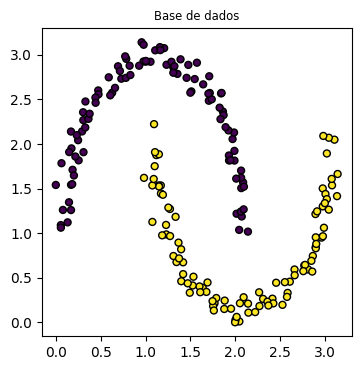

In [15]:
X, y = make_moons(n_samples=200, noise=0.05, random_state=seed)

X = normalize(X, y, range_init=0, range_end=np.pi)

# Running

In [70]:
n_clusters = 2
n_qubits = 2
n_params = 3
n_layers = 4
n_entanglement = 4
embedding_type = 'AE'
qnode = create_qnode(n_qubits, n_entanglement=n_entanglement, embedding_type=embedding_type)

intra_loss_history = []
inter_loss_history = []
cluster_penality_history = []
total_loss_history = []

cost, weights, bias, centroids, score_silhouette, score_davies, score_calinski = train(
    qnode=qnode,
    features=X,
    n_params=n_params,
    n_qubits=n_qubits,
    n_layers=n_layers,
    n_clusters=n_clusters,
    weight_init_max=np.pi,
    optimizer=GradientDescentOptimizer,
    dic_optimizer={'stepsize': 0.1},
    # n_entanglement=n_entanglement,
    # embedding_type=embedding_type,
    cost=cost_function,
    seed=seed,
    iterations=100,
    batch_size=64
)

plot_loss_evolution(intra_loss_history, inter_loss_history, cluster_penality_history, total_loss_history)

TypeError: loop of ufunc does not support argument 0 of type ArrayBox which has no callable log method

In [ ]:
show_clusters(
        weights=weights,
        bias=bias,
        qnode=qnode,
        features=X,
        centroids=centroids,
        x_max=np.pi,
        y_max=np.pi,
        complement=f"{qnode.__name__} | Layers: {n_layers}"
    )

TypeError: show_clusters() got an unexpected keyword argument 'features'